# Broadband polarization beam splitter using anisotropic metamaterial

Polarization beam splitters (PBS) play a vital role in polarization diversity circuits to mitigate the strong polarization dependence of silicon nanophotonic devices. Among the various PBS structures, asymmetrical directional couplers are predominantly employed due to their superior overall performance. Notwithstanding, engineering an on-chip silicon PBS that offers a compact footprint, low loss, exceptional extinction ratio, and particularly, a broad bandwidth, all at once, remains a formidable challenge. The working bandwidth of directional couplers is inherently limited. 

Metamaterials offer an innovative method of manipulating optical responses and regulating light flow. Subwavelength grating (SWG), an anisotropic metamaterial (AM) formed by a one-dimensional array of deeply subwavelength nano-strips, exemplifies these characteristics. SWGs demonstrate strong anisotropy and flattened dispersion, making them extremely useful for polarization manipulation.

In this notebook, we present an ultra-broadband PBS design that makes effective use of AM. The design is based on the research work `Xu, H., Dai, D., & Shi, Y. (2019). Ultra-broadband and ultra-compact on-chip silicon polarization beam splitter by using hetero-anisotropic metamaterials. Laser & Photonics Reviews, 13(4), 1800349.` [DOI: 10.1002/lpor.20180349](https://doi.org/10.1002/lpor.201800349).

The design comprises three SWG sections symmetrically arranged to form a hetero-anisotropic slab, with two AM[100] sections sandwiching a central AM[010] section. The design also utilizes an adiabatic taper structure at the input/output ports, which serves as a converter between the standard channel waveguides and the SWGs. The design goal is to have the TE mode transmitted to the through port while the TM mode will be coupled to the cross port.

<img src="img/pbs_swg_am.png" width="500" alt="Schematic of the PBS">

For more examples utilizing SWGs for on-chip applications, please check out the [waveguide bragg gratings](https://www.flexcompute.com/tidy3d/examples/notebooks/BraggGratings/), [broadband polarizer](https://www.flexcompute.com/tidy3d/examples/notebooks/SWGBroadbandPolarizer/), and [exceptional coupling for waveguide crosstalk reduction](https://www.flexcompute.com/tidy3d/examples/notebooks/ZeroCrossTalkTE/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver


## Simulation Setup

We will focus on the broadband capabilities of the designed PBS over a 200 nm spectrum, ranging from 1450 nm to 1650 nm. This range encapsulates the S-band, C-band, and L-band frequencies.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.45, 1.65, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range


The three materials utilized are silicon, silicon oxide, and SU8. Both silicon and oxide are readily available in the [material library](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/material_library.html). In contrast, SU8 is modelled as a non-dispersive medium.

In [3]:
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

n_su8 = 1.58
su8 = td.Medium(permittivity=n_su8**2)


Determine the geometric parameters. The thickness of the silicon layer is recorded to be 250 nm. The input and output single mode waveguides each have a width $w_{in}$ of 450 nm. The width of the [100] anisotropic metamaterial (AM[100])  $w_{100}$ is 650 nm. The junction between the single mode strip waveguide and the AM region takes on a taper structure, incorporating $n_{tp}=$10 grating periods. The periods $p$ for both the AM[100] and AM[010] are set at 250 nm. The duty cycles $f_{100}$ and $f_{010}$ are set to 0.7 for both metamaterials, with an option for fine-tuning later.

<img src="img/pbs_swg_am_top.png" width="700" alt="Top veiw of the PBS">

In [4]:
t = 0.25  # silicon layer thickness
p = 0.25  # pitch of the swg
w_in = 0.45  # input waveguide width
w_100 = 0.65  # width of the AM[100]
n_tp = 10  # number of periods in the taper region
f_0 = 0.7  # initial duty cycle for the anisotropic metamaterial
inf_eff = 1e3  # effective infinity
buffer = 0.6 * lda0  # buffer spacing


## Mode Analysis

To gain insight into the operational mechanism of the PBS design and to assist future design optimization, we start with a mode analysis. The effective refractive indices of the SWG AM are procured via the effective medium theory. The subsequent formulas elaborate on this:

1. The ordinary refractive index, denoted as $n_o$, is governed by the formula:
   $$
   n_o^2 = f \cdot n_{Si}^2 + (1 - f) \cdot n_{SU8}^2
   $$

   Here, $f$ represents the SWG duty cycle, $n_{Si}$ stands for the refractive index of silicon, and $n_{SU8}$ indicates the refractive index of SU8.

2. The extraordinary refractive index, denoted as $n_e$, is demonstrated as:
   $$
   \frac{1}{n_e^2} = \frac{f}{n_{Si}^2} + \frac{1 - f}{n_{SU8}^2}
   $$

3. The refractive index tensors for various configurations, specifically the anisotropic metamaterial [100] and [010], are depicted as such:
     $$
     n_{[100]} = \text{diag}(n_{[100]}^{xx}, n_{[100]}^{yy}, n_{[100]}^{zz}) = \text{diag}(n_e, n_o, n_o)
     $$
    Similarly,
     $$
     n_{[010]} = \text{diag}(n_{[010]}^{xx}, n_{[010]}^{yy}, n_{[010]}^{zz}) = \text{diag}(n_o, n_e, n_o)
     $$

In this context, $n_o$ and $n_e$ are the ordinary and extraordinary refractive indices respectively. 

By applying the aforementioned refractive index tensors, a mode analysis is conducted on the effective mediums.

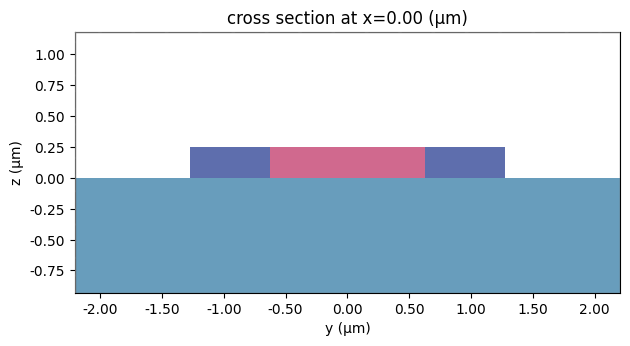

In [5]:
n_si = si.nk_model(frequency=freq0)[0]  # refractive index of silicon

# calculate effective refractive index tensors
n_o = np.sqrt(f_0 * n_si**2 + (1 - f_0) * n_su8**2)
n_e = np.sqrt(1 / (f_0 / n_si**2 + (1 - f_0) / n_su8**2))

# create effective mediums
n_o_medium = td.Medium(permittivity=n_o**2)
n_e_medium = td.Medium(permittivity=n_e**2)
am_100_medium = td.AnisotropicMedium(xx=n_e_medium, yy=n_o_medium, zz=n_o_medium)
am_010_medium = td.AnisotropicMedium(xx=n_o_medium, yy=n_e_medium, zz=n_o_medium)

# create waveguide structures
n_010_example = 5 # use 5 periods for the AM[010] region width as an example
am_010_waveguide = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -n_010_example * p / 2, 0), rmax=(inf_eff, n_010_example * p / 2, t)
    ),
    medium=am_010_medium,
)

am_100_waveguide_left = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -n_010_example * p / 2 - w_100, 0),
        rmax=(inf_eff, -n_010_example * p / 2, t),
    ),
    medium=am_100_medium,
)
am_100_waveguide_right = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, n_010_example * p / 2, 0), rmax=(inf_eff, n_010_example * p / 2 + w_100, t)
    ),
    medium=am_100_medium,
)

# create box structure
box = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, 0)),
    medium=sio2,
)

# create a simulation for the mode solver
mode_solver_sim = td.Simulation(
    center=(0, 0, t / 2),
    size=(buffer, n_010_example * p + 2 * w_100 + 2 * buffer, t + 2 * buffer),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=25, wavelength=lda0),
    structures=[box, am_010_waveguide, am_100_waveguide_left, am_100_waveguide_right],
    run_time=1e-12,
    medium=su8,
)

# create a mode solver
mode_solver = ModeSolver(
    simulation=mode_solver_sim,
    plane=td.Box(
        center=(0, 0, t / 2), size=(0, n_010_example * p + 2 * w_100 + 2 * buffer, t + 2 * buffer)
    ),
    mode_spec=td.ModeSpec(num_modes=6, target_neff=n_si),
    freqs=[freq0],
)

# plot the mode solving cross section
mode_solver.plot()
plt.show()


To ensure accuracy in our process, we execute the server-side mode resolving and subsequently illustrate the mode properties. Utilizing the `TE (Ey) fraction` as a reference, we can discern that the initial two modes align with the first TE modes. Similarly, the third and fifth modes correspond to the first TM modes.

In [6]:
mode_data = run_mode_solver(mode_solver, verbose=False)
mode_data.to_dataframe()


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.266313    0.0          0.983015   
             1                 1.55  2.266243    0.0          0.982896   
             2                 1.55  1.960053    0.0          0.008933   
             3                 1.55  1.877063    0.0          0.979590   
             4                 1.55  1.848565    0.0          0.040660   
             5                 1.55  1.768686    0.0          0.950798   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.858241        0.817122   0.656644  
             1                 0.857676        0.817317   0.655516  
             2                 0.677583        0.977042   0.895539  
             3                 0.932494        0.854730   0.600598  
             4                 0.707929        0.921683   1.215862  
             5                 0.789337        0.875877   1.052148

Plot the field profiles for the initial two TE and TM modes. These results reproduce Fig. 2b in the cited [study](https://doi.org/10.1002/lpor.201800349). The TM0 and TM1 field profiles demonstrate coverage over both the AM[010] and AM[100] regions. In contrast, the even and odd TE super-modes are primarily concentrated in the AM[100] region, indicating a much smaller coupling strength.

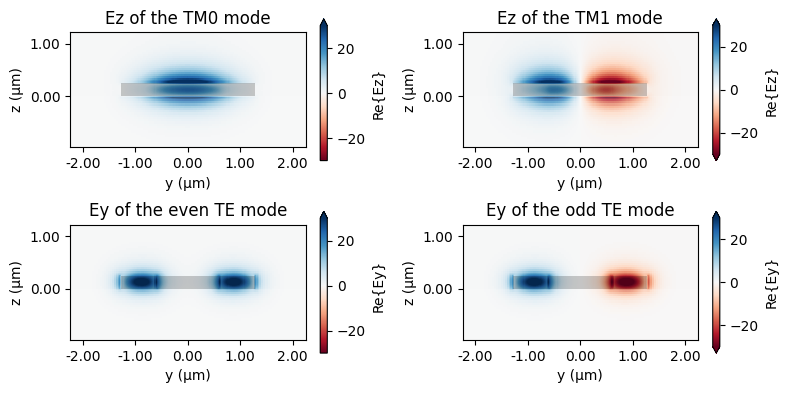

In [7]:
# plot the mode profiles
fig, axes = plt.subplots(2, 2, figsize=(8, 4), tight_layout=True)
mode_solver.plot_field(mode_index=2, field_name="Ez", val="real", vmin=-30, vmax=30, ax=axes[0, 0])
axes[0, 0].set_title("Ez of the TM0 mode")
mode_solver.plot_field(mode_index=4, field_name="Ez", val="real", vmin=-30, vmax=30, ax=axes[0, 1])
axes[0, 1].set_title("Ez of the TM1 mode")
mode_solver.plot_field(mode_index=1, field_name="Ey", val="real", vmin=-30, vmax=30, ax=axes[1, 1])
axes[1, 1].set_title("Ey of the odd TE mode")
mode_solver.plot_field(mode_index=0, field_name="Ey", val="real", vmin=-30, vmax=30, ax=axes[1, 0])
axes[1, 0].set_title("Ey of the even TE mode")
plt.show()


We can calculate the coupling length for TE and TM modes using the formula $L_c = \frac{\lambda}{2(n_{eff}^0-n_{eff}^1)}$, where $n_{eff}^0$ and $n_{eff}^1$ denote the effective indices of the initial two modes. The results demonstrate that the coupling length for TM mode is approximately 7 μm, whilst the coupling length for TE mode is several orders of magnitude larger. Consequently, by designing the coupling region to roughly 7 μm, we can effectively couple the TM mode to the cross port. Conversely, the TE mode is directed solely to the through port, which results in the realization of the PBS functionality.

In [8]:
# calculate TM mode coupling length
n_tm0 = mode_data.n_eff.sel(mode_index=2).values[0]
n_tm1 = mode_data.n_eff.sel(mode_index=4).values[0]
print(f"The coupling length for the TM mode is {lda0/(2*(n_tm0-n_tm1)) :.2f} μm.")

# calculate TE mode coupling length
n_te0 = mode_data.n_eff.sel(mode_index=0).values[0]
n_te1 = mode_data.n_eff.sel(mode_index=1).values[0]
print(f"The coupling length for the TE mode is {lda0/(2*(n_te0-n_te1)) :.2f} μm.")


The coupling length for the TM mode is 6.95 μm.
The coupling length for the TE mode is 11132.14 μm.


## Design Optimization

For the final design configuration, it is crucial to pinpoint the exact coupling length that promotes the maximum coupling of the TM mode to the cross port. The determination of the coupling length is reliant upon the number of grating periods in the AM[100] region, i.e. $n_{100}$. Similarly, the width of the coupling region is governed by the number of grating periods in the AM[010] region, i.e. $n_{010}$. A parameter sweep of both aspects will be conducted to search for the optimal values. The duty cycles for both AM[100] and AM[010] are held at a constant 0.7 in this scenario to guarantee the minimal feature size. However, these values are open to precise adjustment at a later stage.

To start the parameter sweep process, we define a `make_sim` function. This function processes the design parameters and returns a Tidy3D [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation). 

In [9]:
def make_sim(mode_index, n_100, n_010, f_100=f_0, f_010=f_0):
    """
    Constructs and returns a simulation object given the design parameters.

    Args:
        mode_index (int): The index of the mode to excite in the simulation. mode_index=0 for TE and mode_index=1 for TM.
        n_100 (int): Number of SWG periods in AM[100].
        n_010 (int): Number of SWG periods in AM[010].
        f_100 (float, optional): Duty cycle for AM[100].
        f_010 (float, optional): Duty cycle for AM[010].

    Returns:
        td.Simulation
    """
    
    l_c = p * n_100 - (1 - f_100) * p # coupling region length
    l_tp = p * n_tp # taper length
    y_0 = n_010 * p / 2 + (1 - f_010) * p / 2 + w_100 / 2 # y coordinate of the input waveguide center

    # create the swg structures in the coupling region
    am_geos = 0
    for i in range(n_010):
        am_geos += td.Box(
            center=(l_c / 2, (n_010 - 1) * p / 2 - i * p, t / 2), size=(l_c, p * f_010, t)
        )

    for i in range(n_100):
        am_geos += td.Box(center=(f_100 * p / 2 + i * p, y_0, t / 2), size=(p * f_100, w_100, t))
        am_geos += td.Box(center=(f_100 * p / 2 + i * p, -y_0, t / 2), size=(p * f_100, w_100, t))

    am_structure = td.Structure(geometry=am_geos, medium=si)
    
    # create the waveguide taper structures
    vertices = [
        (-inf_eff, y_0 + w_in / 2),
        (-inf_eff, y_0 - w_in / 2),
        (-l_tp - (1 - f_100) * p, y_0 - w_in / 2),
        (-(1 - f_100) * p, y_0),
        (-l_tp - (1 - f_100) * p, y_0 + w_in / 2),
    ]

    taper_in = td.PolySlab(vertices=vertices, axis=2, slab_bounds=(0, t))
    taper_out_bottom = taper_in.rotated(angle=np.pi, axis=2).translated(x=l_c, y=0, z=0)
    taper_out_top = taper_out_bottom.translated(x=0, y=2 * y_0, z=0)

    taper_geos = [taper_in, taper_out_bottom, taper_out_top]
    taper_structure = td.Structure(geometry=td.GeometryGroup(geometries=taper_geos), medium=si)

    # create the swg structures in the taper regions
    taper_widths = np.linspace(w_in, w_100, n_tp + 2)[1:-1]
    taper_am_geos = []
    for i in range(n_tp):
        taper_am = td.Box(
            center=(-l_tp + f_100 * p / 2 + i * p, y_0, t / 2), size=(f_100 * p, taper_widths[i], t)
        )
        taper_am_geos += [
            taper_am,
            taper_am.rotated(angle=np.pi, axis=2).translated(x=l_c, y=0, z=0),
            taper_am.rotated(angle=np.pi, axis=2).translated(x=l_c, y=2 * y_0, z=0),
        ]
    taper_am_structure = td.Structure(
        geometry=td.GeometryGroup(geometries=taper_am_geos), medium=si
    )

    # add a mode source as excitation
    mode_spec = td.ModeSpec(num_modes=2, target_neff=n_si)
    mode_source = td.ModeSource(
        center=(-l_tp - buffer / 2, y_0, t / 2),
        size=(0, 4 * w_in, 6 * t),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="+",
        mode_spec=mode_spec,
        mode_index=mode_index,
    )

    # add a mode monitor to measure transmission at the through port
    mode_through = td.ModeMonitor(
        center=(l_c + l_tp + buffer / 2, y_0, t / 2),
        size=mode_source.size,
        freqs=freqs,
        mode_spec=mode_spec,
        name="through",
    )
    
    # add a mode monitor to measure transmission at the cross port
    mode_cross = td.ModeMonitor(
        center=(l_c + l_tp + buffer / 2, -y_0, t / 2),
        size=mode_source.size,
        freqs=freqs,
        mode_spec=mode_spec,
        name="cross",
    )

    # add a field monitor to visualize field distribution at z=t/2
    field_monitor = td.FieldMonitor(
        center=(0, 0, t / 2),
        size=(td.inf, td.inf, 0),
        freqs=[freq0],
        interval_space=(2, 2, 1),
        name="field",
    )

    run_time = 1.5e-12  # simulation run time

    # construct simulation
    sim = td.Simulation(
        center=(l_c / 2, 0, t / 2),
        size=(2 * l_tp + l_c + buffer * 2, n_010 * p + w_100 * 2 + 2 * buffer, 10 * t),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=25, wavelength=lda0),
        structures=[am_structure, taper_structure, taper_am_structure, box],
        sources=[mode_source],
        monitors=[mode_through, mode_cross, field_monitor],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
        medium=su8,
    )

    return sim


The simulation setup is relatively complex due to the SWG structures. To validate the correctness of the setup, we construct a sample simulation and render its 3D visualization.

In [10]:
sim = make_sim(mode_index=1, n_100=30, n_010=5)
sim.plot_3d()


Visualize the grid to ensure that it's refined enough to resolve the small features.

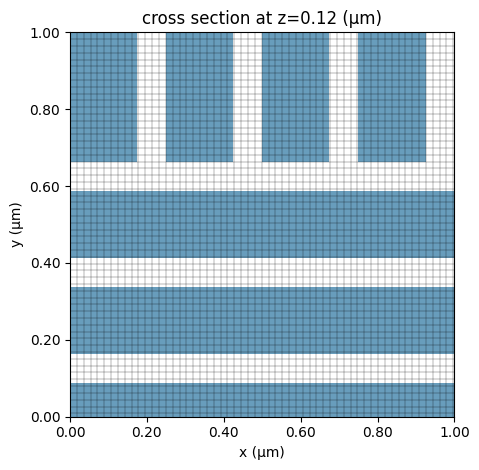

In [11]:
ax = sim.plot(z=t / 2, monitor_alpha=0)
sim.plot_grid(z=t / 2, ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
plt.show()


The purpose of this notebook is solely for demonstration, thus, we will only be exploring a limited parameter space. For a more extensive exploration, a similar procedure can be adopted.

Prior to initiating a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) of simulations, it is important to get an estimate of the potential FlexCredit cost. This helps users by keeping them informed about possible expenses associated with the simulations and protects against accidental misuse of credits.

In [12]:
# parameter sweep ranges
n_100_list = list(range(24, 36, 2))
n_010_list = list(range(5, 7, 1))

# create simulations
sims = {
    f"mode_index={mode_index}; n_100={n_100}; n_010={n_010};": make_sim(mode_index, n_100, n_010)
    for mode_index in [0, 1]
    for n_100 in n_100_list
    for n_010 in n_010_list
}

# create batch
batch = web.Batch(simulations=sims, verbose=True)
_ = batch.estimate_cost()


09:06:41 Eastern Standard Time Maximum FlexCredit cost: 12.125 for the whole    
                               batch.

Run the batch of simulations and verify the real cost. This cost is typically significantly reduced compared to the estimated one because of early shutoff.

In [13]:
batch_results = batch.run(path_dir="data")
_ = batch.real_cost()


Output()

                               Started working on Batch containing 24 tasks.

09:07:02 Eastern Standard Time Maximum FlexCredit cost: 12.125 for the whole    
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

09:07:14 Eastern Standard Time Batch complete.

Output()

09:07:46 Eastern Standard Time Total billed flex credit cost: 5.630.

## Result Visualization

Let's now move towards visualization of our results. We begin by extracting and plotting the transmission at the central frequency as a function of both $n_{010}$ and $n_{100}$.

In [14]:
def cal_transmission_at_freq0(mode_index, n_010):
    """
    Calculates the transmission at the central frequency as a function of n_100 for a given mode index 
    and n_010

    Args:
        mode_index (int): The index of the mode for which transmission is calculated. mode_index=0 for TE and mode_index=1 for TM.
        n_010 (int): The number of periodic elements along the y-direction.

    Returns:
        tuple[list[float], list[float]]: A tuple containing two lists:
            - `cross`: Power transmission values to the cross port.
            - `through`: Power transmission values to the through port.
    """
    cross = [
        np.abs(
            batch_results[f"mode_index={mode_index}; n_100={n_100}; n_010={n_010};"]["cross"]
            .amps.sel(mode_index=mode_index, direction="+")
            .sel(f=freq0, method="nearest")
            .values
        )
        ** 2
        for n_100 in n_100_list
    ]

    through = [
        np.abs(
            batch_results[f"mode_index={mode_index}; n_100={n_100}; n_010={n_010};"]["through"]
            .amps.sel(mode_index=mode_index, direction="+")
            .sel(f=freq0, method="nearest")
            .values
        )
        ** 2
        for n_100 in n_100_list
    ]

    return cross, through


In [15]:
# hex codes of the colors used for plotting
colors = {
    "TM_cross": "#dc0154",
    "TM_through": "#f5a67a",
    "TE_cross": "#aaa3f0",
    "TE_through": "#3130bc",
}


def plot_transmission_at_freq0(cross, through, n_010, mode, ax):
    """
    Plots the transmission values for cross and through ports at the central frequency as a function of n_100

    Args:
        cross (list[float]): List of transmission values for the cross port.
        through (list[float]): List of transmission values for the through port.
        n_010 (int): Number of periods in the AM[010]
        mode (str): Input mode type (e.g., "TE" or "TM").
        ax: Matplotlib Axes object on which to plot.
    """
    ax.plot(n_100_list, cross, color=colors[f"{mode}_cross"], linewidth=2, label="Cross port")
    ax.plot(n_100_list, through, color=colors[f"{mode}_through"], linewidth=2, label="Through port")
    ax.set_title(f"n_010={n_010}; {mode.upper()} input")
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect(aspect=5)
    ax.set_xlabel("n_100")
    ax.set_ylabel("Transmission")
    ax.legend()
    ax.grid()


The outcome replicates a portion of Figure 3 from the cited [paper](https://doi.org/10.1002/lpor.201800349). It is evident that the optimal outcome is achieved with $n_{100}=30$ and $n_{010}=5$.

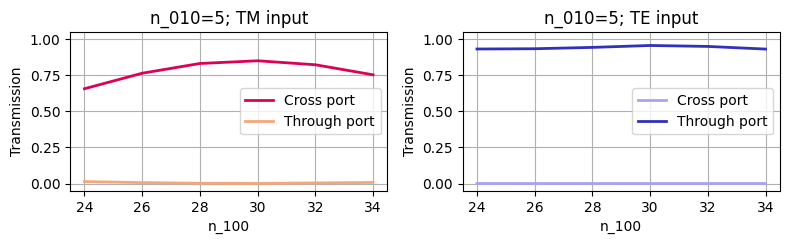

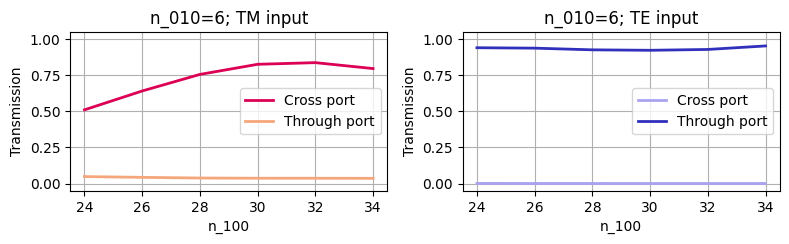

In [16]:
for n_010 in n_010_list:
    fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharex=True)

    # TM
    cross_tm, through_tm = cal_transmission_at_freq0(1, n_010)
    plot_transmission_at_freq0(cross_tm, through_tm, n_010, "TM", axes[0])

    # TE
    cross_te, through_te = cal_transmission_at_freq0(0, n_010)
    plot_transmission_at_freq0(cross_te, through_te, n_010, "TE", axes[1])

    plt.tight_layout()
    plt.show()


Next, we generate the transmission spectra plots for both TE and TM input simulations.

In [17]:
def get_spectra(sim_data):
    """
    Calculates the power spectra for the through and cross ports 
    from simulation data.

    Args:
        sim_data: td.SimulationData

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
            - Power spectrum for mode_index=0 at the through port.
            - Power spectrum for mode_index=0 at the cross port.
            - Power spectrum for mode_index=1 at the through port.
            - Power spectrum for mode_index=1 at the cross port.
    """
    return (
        np.abs(sim_data["through"].amps.sel(mode_index=0, direction="+").values) ** 2,
        np.abs(sim_data["cross"].amps.sel(mode_index=0, direction="+").values) ** 2,
        np.abs(sim_data["through"].amps.sel(mode_index=1, direction="+").values) ** 2,
        np.abs(sim_data["cross"].amps.sel(mode_index=1, direction="+").values) ** 2,
    )


def plot_spectra(sim_data, mode, field_component, field_vmin, field_vmax):
    """
    Plots the spectra and field distribution for a given simulation result.

    Parameters:
        sim_data: Simulation data object.
        mode: "TE" or "TM".
        field_component: Field component to plot (e.g., "Hz", "Ez").
        field_vmin: Minimum value for field plot colormap.
        field_vmax: Maximum value for field plot colormap.
    """
    # extract spectra
    te_through, te_cross, tm_through, tm_cross = get_spectra(sim_data)

    # choose the correct data based on mode
    if mode == "TE":
        through = te_through
        cross = te_cross
        title = "TE input"
    elif mode == "TM":
        through = tm_through
        cross = tm_cross
        title = "TM input"
    else:
        raise ValueError("Invalid mode. Use 'TE' or 'TM'.")

    # create figure
    fig, axes = plt.subplots(2, 1, figsize=(5, 7))

    # plot spectra
    axes[0].plot(
        ldas,
        10 * np.log10(through),
        color=colors[f"{mode}_through"],
        linewidth=2,
        label="Through port",
    )
    axes[0].plot(
        ldas, 10 * np.log10(cross), color=colors[f"{mode}_cross"], linewidth=2, label="Cross port"
    )
    axes[0].set_title(title)
    axes[0].set_ylim(-50, 2)
    axes[0].set_xlabel("Wavelength (μm)")
    axes[0].set_ylabel("Transmission (dB)")
    axes[0].legend()
    axes[0].grid()

    # plot field distribution
    sim_data.plot_field(
        "field", field_component, "real", vmin=field_vmin, vmax=field_vmax, ax=axes[1]
    )

    # adjust layout and display
    plt.tight_layout()
    plt.show()


The results show a great PBS performance.

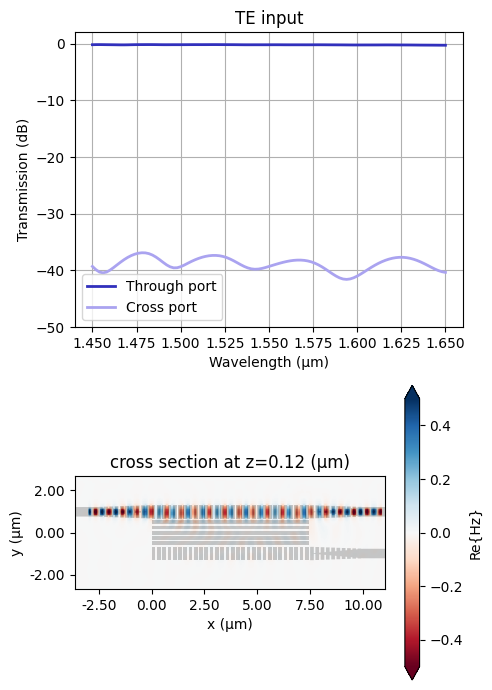

In [18]:
# plot TE simulation results
sim_data_te = batch_results["mode_index=0; n_100=30; n_010=5;"]
plot_spectra(
    sim_data=sim_data_te,
    mode="TE",
    field_component="Hz",
    field_vmin=-0.5,
    field_vmax=0.5,
)


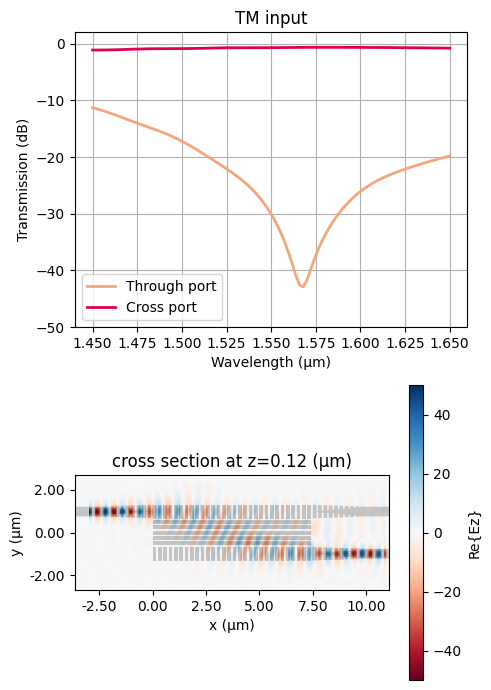

In [19]:
# plot TM simulation results
sim_data_tm = batch_results["mode_index=1; n_100=30; n_010=5;"]
plot_spectra(
    sim_data=sim_data_tm,
    mode="TM",
    field_component="Ez",
    field_vmin=-50,
    field_vmax=50,
)


Finally, we determine the polarization extinction ratio (PER) specifically for the TM input scenario.

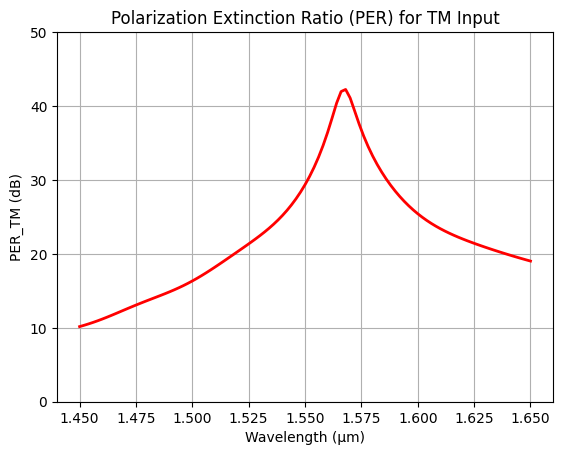

In [20]:
_, _, tm_through, tm_cross = get_spectra(sim_data_tm)

per_tm = 10 * np.log10(tm_cross / tm_through)

plt.plot(ldas, per_tm, c="red", linewidth=2)
plt.title("Polarization Extinction Ratio (PER) for TM Input")
plt.ylim(0, 50)
plt.xlabel("Wavelength (μm)")
plt.ylabel("PER_TM (dB)")
plt.grid()
plt.show()


## Final Remarks

This notebook demonstrates the design process of a broadband PBS based on SWG AM. The result shows low loss and large bandwidth. However, ideally we would like to have a flat polarization extinction ratio. As demonstrated in the referenced paper, this can be achieved by further fine-tuning the duty cycle of the AM[100]. We don't demonstrate this part in this notebook and leave this part for the readers as an exercise. Readers are encouraged to explore additional opportunities to optimize the design by introducing apodization or using inverse design optimization, for example.